# ROSES Array and Network Processing

This is a companion data exercise for the ROSES 2020 class on Array and Network Methods.

Stephen Arrowsmith (sarrowsmith@smu.edu)

In [1]:
%matplotlib inline
import roses_array as ra
from obspy import read
import utm
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

## 1. Array Processing

The array processing algorithms described below are applied to data from the 2018/12/18 Bering Sea bolide. It's one of the most energetic events detected with optical measurements: https://cneos.jpl.nasa.gov/fireballs/

The NASA estimated yield is 173 kT. For reference, the bomb dropped over Hiroshima was about 15 kT, and the IMS infrasound network is designed to detect events greater than 1 kT.

### Reading infrasound data

We're going to read data from the IMS infrasound array called I53US, which is in Fairbanks, AK. The array records a signal that has propagated in a waveguide between the ground and the top of the stratosphere. We'll apply a Cosine taper and bandpass filter it from 0.1 - 5 Hz.

In [2]:
st = read('I53US.pickle')
st.taper(type='cosine', max_percentage=0.05, max_length=60)
st.filter('bandpass', freqmin=0.1, freqmax=5)

8 Trace(s) in Stream:
IM.I53H1..BDF | 2018-12-19T01:30:00.000000Z - 2018-12-19T02:30:00.000000Z | 20.0 Hz, 72001 samples
IM.I53H2..BDF | 2018-12-19T01:30:00.000000Z - 2018-12-19T02:30:00.000000Z | 20.0 Hz, 72001 samples
IM.I53H3..BDF | 2018-12-19T01:30:00.000000Z - 2018-12-19T02:30:00.000000Z | 20.0 Hz, 72001 samples
IM.I53H4..BDF | 2018-12-19T01:30:00.000000Z - 2018-12-19T02:30:00.000000Z | 20.0 Hz, 72001 samples
IM.I53H5..BDF | 2018-12-19T01:30:00.000000Z - 2018-12-19T02:30:00.000000Z | 20.0 Hz, 72001 samples
IM.I53H6..BDF | 2018-12-19T01:30:00.000000Z - 2018-12-19T02:30:00.000000Z | 20.0 Hz, 72001 samples
IM.I53H7..BDF | 2018-12-19T01:30:00.000000Z - 2018-12-19T02:30:00.000000Z | 20.0 Hz, 72001 samples
IM.I53H8..BDF | 2018-12-19T01:30:00.000000Z - 2018-12-19T02:30:00.000000Z | 20.0 Hz, 72001 samples

Next, we'll plot the data using the built-in ObsPy Stream plot method. Try zooming in on the signal and zooming in on the pre-event noise. Does it look like the signal is coherent across the array? What about the noise?

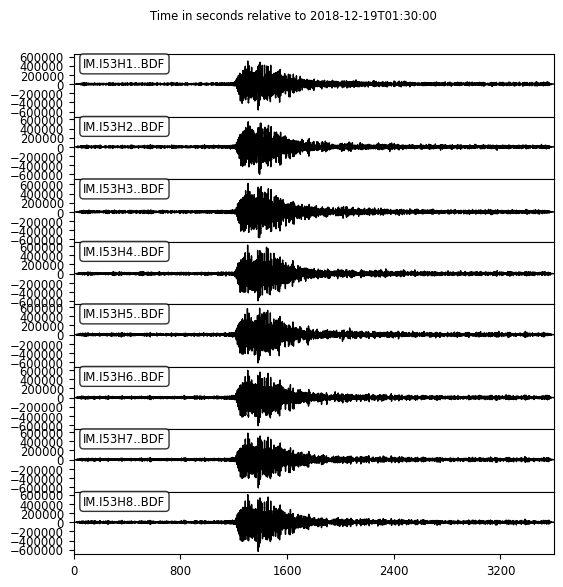

In [3]:
# %pylab notebook

fig = st.plot(handle=True, method='full', type='relative', size=(600, 600))
#fig.gca().set_xlim((1000,1800))

### Plotting the array coordinates

I have this bad habit of sticking the sensor metadata in the ObsPy Trace objects under the sac attribute. You can access it using the handy get_array_coords method I provided for you. We can use this to view the array coordinates.

In [4]:
X, stn = ra.get_array_coords(st, 'I53H6')

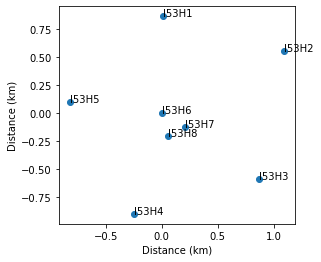

In [5]:
# %pylab notebook

plt.plot(X[:,0], X[:,1], 'o')
for i in range(0, len(stn)):
    plt.text(X[i,0], X[i,1], stn[i])
plt.xlabel('Distance (km)')
plt.ylabel('Distance (km)')
plt.gca().set_aspect('equal')

What frequency range is this array well suited for?

(the average speed of sound in air is ~340 m/s, although Fairbanks is probably pretty cold...)

### Plotting slowness-plane power

This figure is conventionally called an FK plot, as it is normally computed in the frequency domain using the Frequency-Wavenumber algorithm. We're going to define a time window, and use some code I completely ripped out of ObsPy in order to plot an FK image (why doesn't ObsPy provide a handle for this?)

In [6]:
# Defining a start time to compute an FK plot for:
time_start = st[0].stats.starttime+1200
time_end = st[0].stats.starttime+1300

GC backazimuth = 265.9840120630472


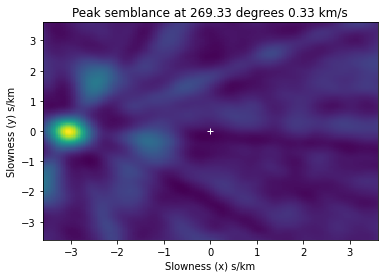

In [7]:
# %pylab notebook

baz, dist = ra.gc_backzimuth(st, 172.4, 56.9)
print('GC backazimuth =', baz)
fk = ra.plotFK(st, time_start, time_end, 
                    0.5, 5, 
                    sll_x=-3.6, slm_x=3.6, sll_y=-3.6, slm_y=3.6, 
                    sl_s=3.6/100, normalize=False)

### Computing a beam

Now that we've estimated a slowness vector that corresponds to the direction-of-arrival (DOA), let's compute the beam for that DOA. To do this, we first compute the time shifts for the backazimuth and phase velocity, then convert these to integer shifts, and finally compute and plot the beam.

In [8]:
# Computing array coordinates:
X, stnm = ra.get_array_coords(st, 'I53H6')

# Computing time-shifts for estimated signal DOA:
t_shifts = ra.compute_tshifts(X, 269.33, 0.33)

# Computing integer time shifts given the sampling interval:
int_shifts = [int(x) for x in np.array(t_shifts)/st[0].stats.delta]

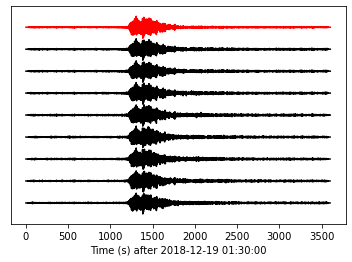

In [9]:
# %pylab notebook

beam = ra.plot_beam(st, int_shifts, 'I53H6', return_beam=True)

### Computing DOA with sliding-window array processing

The next code block applies the least-squares method for estimating the DOA in a sliding-window. You can specify the start and end time to process, the length of the time window, and the overlap. The output is a list of times, phase velocities, and backazimuths. The subsequent plot shows the results with the beamformed waveform for comparison.

In [10]:
tstart = 500; tend = 2500; twin = 15; overlap = twin/4
T, V, B = ra.sliding_time_array_lsq(st, X, tstart, tend, twin, overlap)

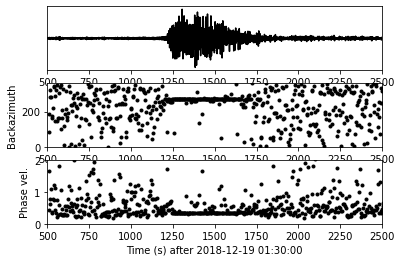

In [11]:
# %pylab notebook

st = ra.add_beam_to_stream(st, beam, 'I53H6')
ra.plot_sliding_window(st, T, B, V, v_max=2., twin_plot=[tstart,tend])

What do you notice about the estimates of direction-of-arrival prior to ~1250 s and after ~1750 s? What could be a disadvantage of using a time window that is (a) too short, and (b) too long? 

### Performing sliding-window FK

The next two code blocks essentially implement the same procedure, but using the grid-search method and the built-in ObsPy Frequency-Wavenumber method.

In [12]:
st = st.select(station='I53*')    # Remove beam trace
slid_fk = ra.sliding_time_array_fk(st, 500, 2500, win_len=15, win_frac=0.25, frqlow=0.1, frqhigh=5,
                          sll_x=-3.6, slm_x=3.6, sll_y=-3.6, slm_y=3.6, sl_s=0.18)

In [14]:
# %pylab notebook

# Convert times to seconds after Stream start time:
# T = (slid_fk[:,0] - date2num(st[0].stats.starttime.datetime))*86400
T = (slid_fk[:,0] - np.date2num(st[0].stats.starttime.datetime))*86400

# Convert backazimuths to degrees from North:
B = slid_fk[:,3] % 360.

# Convert slowness to phase velocity:
V = 1/slid_fk[:,4]

# Semblance:
S = slid_fk[:,1]

#st = add_beam_to_stream(st, beam, 'I53H6')
ra.plot_sliding_window(st, T, B, V, C=S, v_max=2., element='I53H1', twin_plot=[tstart,tend])

AttributeError: module 'numpy' has no attribute 'date2num'

## 2. Local Similarity

The next set of code blocks implement the Local Similarity method on data from the Oklahoma Wavefields experiment, described here: https://pubs.geoscienceworld.org/ssa/srl/article/89/5/1923/543213/A-Community-Experiment-to-Record-the-Full-Seismic

Here are some challenge exercises:
- Update the code to allow for a variable number of nearest neighbors (it is currently hardwired for 2)
- Change the number of nearest neighbors to 5 and 10 and see how that affects the results. What are the fundamental limits of this techique in terms of distance and signal frequency?
- Explore different filter bands (try 1/3 Octave bands)
- Run on a 1-day time period, define a suitable trigger threshold, and make a catalog of detections

In [15]:
st = read('WAVEFIELDS.pickle')

### Converting locations to UTM and finding nearest neighbor stations

We're going to use the UTM package to convert locations to UTM coordinates (meters) and the sklearn package to find the nearest 2 neighbors for each station.

In [16]:
# Computing X and Y locations (in meters) by converting from lat, lon to UTM:
X = np.zeros((len(st), 2))
for i in range(0, len(st)):
    E, N, _, _ = utm.from_latlon(st[i].stats.sac.stla, st[i].stats.sac.stlo)
    X[i,0] = E; X[i,1] = N

Text(0, 0.5, 'Northing (m)')

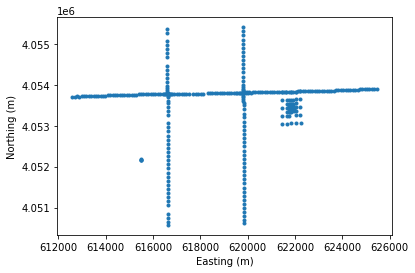

In [17]:
# %pylab notebook

plt.plot(X[:,0], X[:,1], '.')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

#### Hint:
Never re-invent the wheel *unless your goal is to gain understanding*:

https://scikit-learn.org/stable/modules/neighbors.html

In [18]:
# Computing distances and indices to nearest neighboring stations:
nbrs = NearestNeighbors(n_neighbors=3, algorithm='auto', metric='euclidean').fit(X)
distances, ix = nbrs.kneighbors(X)

In [19]:
print(X.shape)
print(distances.shape)

(357, 2)
(357, 3)


In [20]:
ix[190:210,:]

array([[190, 333, 191],
       [191, 190, 192],
       [192, 193, 191],
       [193, 192, 194],
       [194, 195, 193],
       [195, 196, 194],
       [196, 195, 197],
       [197, 198, 196],
       [198, 199, 197],
       [199, 198, 200],
       [200, 201, 199],
       [201, 200, 202],
       [202, 203, 201],
       [203, 204, 202],
       [204, 203, 205],
       [205, 206, 204],
       [206, 205, 207],
       [207, 208, 206],
       [208, 207, 209],
       [209, 210, 208]])

In [21]:
distances[190:210,:]

array([[   0.        ,   52.94296758,  100.51701697],
       [   0.        ,  100.51701697,  100.62842447],
       [   0.        ,   95.52632196,  100.62842447],
       [   0.        ,   95.52632196,  105.51789849],
       [   0.        ,  100.62917411,  105.51789849],
       [   0.        ,  100.51777744,  100.62917411],
       [   0.        ,  100.51777744,  100.6291442 ],
       [   0.        ,  100.51774739,  100.6291442 ],
       [   0.        ,  100.51737436,  100.51774739],
       [   0.        ,  100.51737436,  100.62770815],
       [   0.        ,  100.51674765,  100.62770815],
       [   0.        ,  100.51674765,  100.62763852],
       [   0.        ,  100.51862801,  100.62763852],
       [   0.        ,  100.51682217,  100.51862801],
       [   0.        ,  100.51682217,  100.63156898],
       [   0.        ,  100.5233588 ,  100.63156898],
       [   0.        ,  100.5233588 ,  100.64859239],
       [   0.        ,  100.52141798,  100.64859239],
       [   0.        ,  100.

In [22]:
np.max(distances)

294.43294600878198

### Looking at the correlation for a single station

The next set of code blocks look at the correlation between the i'th station (where i can be adjusted) and the two other geographically closest stations.

In [23]:
# Taking an example station (i'th station):
i = 127
print('Nearest stations =', ix[i,:])

Nearest stations = [127 128 129]


Text(0, 0.5, 'Northing (m)')

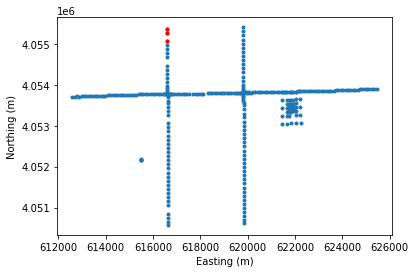

In [24]:
# %pylab notebook

plt.plot(X[:,0], X[:,1], '.')
plt.plot(X[ix[i,:],0], X[ix[i,:],1], 'r.')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

Text(0.5, 0, 'Time (s) rel. to USGS origin time')

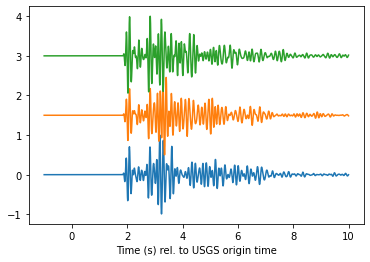

In [25]:
# %pylab notebook

# All the traces have the same start/end times and sampling rate:
nsamp = len(st[0].data)
t = np.linspace(-1., 10., nsamp)

data = np.zeros((3, nsamp))
k = 0; l = 0
for j in ix[i,:]:
    data[l,:] = st[j].data/np.max(np.abs(st[j].data))
    plt.plot(t, k + data[l,:])
    k = k + 1.5; l = l + 1
plt.xlabel('Time (s) rel. to USGS origin time')

Numpy computes the cross-correlation defined by:

$R(k) = \sum_n x(n+k) \overline{y(n)}$

The normalized cross-correlation can be calculated from:

$C(k) = \frac{\sum_n \left( x(n+k) - \mu_x \right) \overline{\left( y(n) - \mu_y \right)}}{n \sigma_x \sigma_y}$

https://en.wikipedia.org/wiki/Cross-correlation

In [26]:
def norm_xcorr(a, b, max_lag=10):
    '''
    Adds normalization to the NumPy cross correlation function and returns the maximum within
    a time lag limit
    
    Returns the maximum correlation
    '''
    
    a = (a - np.mean(a)) / (np.std(a) * len(a))
    b = (b - np.mean(b)) / (np.std(b))
    xcorr = np.correlate(a, b, 'full')
    
    i = len(a)-1                       # Zeroth lag
    xcorr = xcorr[i-max_lag:i+max_lag]
    return np.max(xcorr)

# Defining the number of samples in the moving time window:
delt = 1.
nsamp_win = int(st[0].stats.sampling_rate * delt)

# Defining maximum lag for computing the correlation in each time window:
max_dist = np.max(distances) /1000.    # Maximum inter-station distance (km)
v_min = 3.5                            # Slowest wave velocity (km/s)
t_max = max_dist/v_min                 # Maximum inter-station travel time (s)
i_max = int(t_max/st[0].stats.delta)   # Maximum necessary shift in samples

# Computing the max correlation in a moving time window:
C = []; L = []
l = 0
while l < nsamp-nsamp_win:
    data_l = data[:,l:l+nsamp_win]
    c1 = norm_xcorr(data_l[0,:], data_l[1,:], max_lag=i_max)
    c2 = norm_xcorr(data_l[0,:], data_l[2,:], max_lag=i_max)
    C.append((c1+c2)/2.)
    L.append(l + int(nsamp_win/2))
    l = l + int(nsamp_win/4)

Text(0.5, 0, 'Time (s) rel. to USGS origin time')

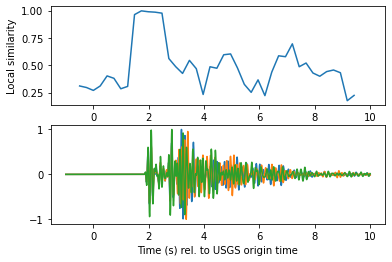

In [27]:
# %pylab notebook

ax = plt.subplot(2,1,1)
plt.plot(t[L], C)
plt.ylabel('Local similarity')
plt.subplot(2,1,2, sharex=ax)
plt.plot(t, data[0,:])
plt.plot(t, data[1,:])
plt.plot(t, data[2,:])
plt.xlabel('Time (s) rel. to USGS origin time')

### Obtaining a network similarity

The next goal is to obtain a network similarity by stacking the individual similarity traces.

In [28]:
C_stack = []

for i in range(0, ix.shape[0]):
    
    # Extracting the data for the i'th station and neighbors:
    data = np.zeros((3, nsamp))
    k = 0; l = 0
    for j in ix[i,:]:
        data[l,:] = st[j].data/np.max(np.abs(st[j].data))
        l = l + 1
    
    # Computing the max correlation in a moving time window:
    C = []; L = []
    l = 0
    while l < nsamp-nsamp_win:
        data_l = data[:,l:l+nsamp_win]
        c1 = norm_xcorr(data_l[0,:], data_l[1,:], max_lag=i_max)
        c2 = norm_xcorr(data_l[0,:], data_l[2,:], max_lag=i_max)
        C.append((c1+c2)/2.)
        L.append(l + int(nsamp_win/2))
        l = l + int(nsamp_win/4)
    
    C_stack.append(C)

C_stack = np.array(C_stack)
C_stack2D = C_stack.copy()
C_stack = C_stack.sum(axis=0)/ix.shape[0]

Text(0.5, 0, 'Time (s) rel. to USGS origin time')

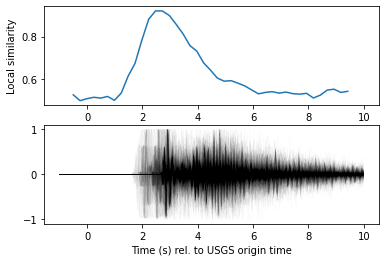

In [29]:
# %pylab notebook

ax = plt.subplot(2,1,1)
plt.plot(t[L], C_stack)
plt.ylabel('Local similarity')
plt.subplot(2,1,2, sharex=ax)
for i in range(0, ix.shape[0]):
    plt.plot(t, st[i].data/np.max(np.abs(st[i].data)), 'k', linewidth=0.01)
plt.xlabel('Time (s) rel. to USGS origin time')